In [1]:
import warnings
import numpy as np
from scipy.signal import lfilter

def loudness_algoritmo_multiChannel(buffer,loudness_deseado,fs = 48000,Tg_f = 0.4): 
    '''    
    Parameters
    ----------
    buffer : float
        Matriz con datos de la señal de audio a procesar. Cada fila implica un canal distinto
    loudness_deseado : float 
        Loudness deseado en dB
    fs : frecuencia de muestreo, optional
        Frecuencia a la que fue muestreado el sistema. The default is 48000.
    Tg : float, optional
        Tiempo de compuerta. The default is 0.4'

    Returns
    Valor de loudness relativo al valor deseado.
    -------
    TYPE
        Funcion que recibe un buffer de "N x Canales" muestras a una frecuencia de muestreo "Fs"
        tiempo de gate y el loudness deseado. 
        Devuelve el loudness relativo respecto al loduness deseado
    '''
    
    #Verifico si se esta analizando un canal o varios
    if buffer.ndim == 1:
        buffer = buffer.reshape(1,-1) # Un unico canal dimensiono a matriz para que funcione el algoritmo

    num_channels,num_samples = buffer.shape 
    
    ### Parametros para algoritmo
    T_f = num_samples/ fs ## Periodo completo de la señal
    overlap = 0.75
    step = 1 - overlap
    number_of_windows =int((T_f - Tg_f)/(Tg_f*step))  
    GI= [1,1,1,1.41,1.41] # coeficientes de los canales
    gama_a = -70 # LKFS
        
    out = np.zeros((num_channels,num_samples)) # Genero matiz donde guardo los resultados del filtrado
    
    ### Coeficientes de filtros
    
    num_preFilter= [1.53512485958697,-2.69169618940638,1.19839281085285]
    den_preFilter= [1,-1.69065929318241,0.73248077421585]

    num_weightingFilter= [1,-2,1]
    den_weightingFilter= [1,-1.99004745483398,0.99007225036621]
    
    ### Aplico filtros al buffer de X canales
    for channel in range(num_channels):
        out[channel] = lfilter(num_preFilter, den_preFilter, buffer[channel])
        out[channel] = lfilter(num_weightingFilter, den_weightingFilter, out[channel])

    ### Calculo la potencia de cada ventana para cada canal
        
    z_ij = np.zeros((num_channels,number_of_windows))  # Genero matiz donde guardo los valores de las ventanas  
    
    for channel in range(num_channels):
        integral_ij = np.array([ np.sum(out[channel][ int(Tg_f*fs*(j*step)) : int(Tg_f*fs*(j*step+1) + 1)]**2) for j in range(0,number_of_windows)]) 
        z_ij[channel] = ((1/(Tg_f*fs)) * integral_ij)
    
    ### Calculo el loudness de cada ventana
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)    
        loudness_j = -0.691 + 10*np.log10( np.sum([GI[i] * z_ij[i] for i in range(num_channels)],axis = 0) ) # Axis = 0 suma en forma de columnas
    
    ### Identifico muestras por encima del nivel minimo
    
    posiciones_validas = np.where(loudness_j > gama_a)
    
    ### Calculo el loudness absoluto
    
    Jg_mod = len(posiciones_validas[0])
    primer_suma = np.sum(z_ij,axis = 0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_abs = -0.695 + 10* np.log10( np.sum(primer_suma[posiciones_validas])/Jg_mod ) 
    
    ### Calculo coeficiente para el calculo de loudness relativo
    
    gama_b = loudness_abs - 10
    
    ### Identifico muestras por encima del nivel minimo
    
    posiciones_validas = np.where(loudness_j > gama_b)
    Jg_mod = len(posiciones_validas[0])
    
    ### Calculo el loudness Relativo
    
    primer_suma = np.sum(z_ij,axis = 0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_relativo = -0.695 + 10* np.log10( np.sum(primer_suma[posiciones_validas])/Jg_mod ) - loudness_deseado
    
    return loudness_relativo
    

In [8]:
import matplotlib.pyplot as plt
from collections import deque
from pydub import AudioSegment
sample_rate = 48000

def analyse_signal_realTime_multichannel(name,loudness_target):
    
    Tg = 0.4 # tiempo de ventana
    T= 3 # Tiempo de buffer
    sample_rate = 48000  # Sample rate en Hz (48 kHz)
    
    audio = AudioSegment.from_mp3(name)

    frecuencia_muestreo = audio.frame_rate
    if frecuencia_muestreo != sample_rate:
        print(frecuencia_muestreo)
        return False

    bytes_por_muestra = audio.sample_width ## Cuanto bytes tiene cada muestra 

    duracion_total = audio.duration_seconds

    ### Buffer donde almaceno todos los samples
    size_buff = int( sample_rate * T )
    buffer_l = deque(maxlen= size_buff) 
    buffer_r = deque(maxlen= size_buff)
    buffer_loudness = []
    
    i=0
    
    while i*Tg < duracion_total:

        # Corta el segmento de audio en 0.4 segundos (simulo el real time)
        segmento = audio[i*Tg*1000:(i+1)*Tg*1000]# extraigo una ventana de 0,4 segundos 

        i +=1

        muestra_bytes_l = segmento.split_to_mono()[0].raw_data
        muestra_bytes_r = segmento.split_to_mono()[1].raw_data

        for i2 in range(0, len(muestra_bytes_l), bytes_por_muestra): # Los datos son de 16bits y hay que guardarlos en un buffer

            # Desempaquetar los bytes en un valor entero con signo y Agregar la muestra a la lista
            buffer_l.append(float(int.from_bytes(muestra_bytes_l[i2:i2+bytes_por_muestra], byteorder='little', signed=True))) 
            buffer_r.append(float(int.from_bytes(muestra_bytes_r[i2:i2+bytes_por_muestra], byteorder='little', signed=True))) 
       
    ## No mido Loudness hasta que el buffer este lleno
        if len(buffer_l)< size_buff-1:
            continue

        buff_to_send = np.vstack((list(buffer_l), list(buffer_r)))
        
        loudnes_relativo = loudness_algoritmo_multiChannel(buff_to_send,loudness_deseado = loudness_target)
        
        buffer_loudness.append(loudnes_relativo)
        
        #print(f"El valor de loudness rel={loudnes_relativo} ")

    time_captured = np.linspace(0,duracion_total,len(buffer_loudness))# en segundos
    
    return time_captured,buffer_loudness

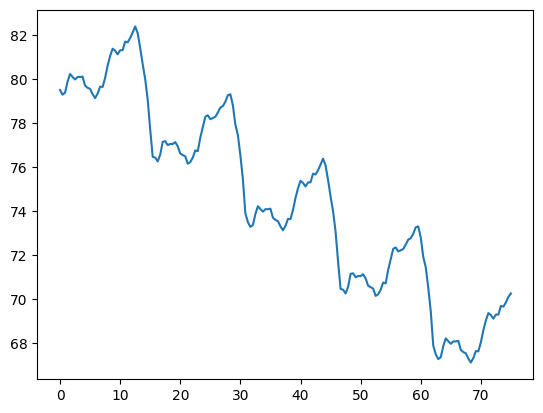

In [9]:
time, data =analyse_signal_realTime_multichannel("Muestras Audio/Muestra2 - volume decrease.mp3",0) 
plt.plot(time, data, label='Loudness')